Import các thư viện cần thiết

In [3]:
# Import các thư viện cần thiết
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    BatchNormalization,
    Permute,
    TimeDistributed,
    Bidirectional,
    GRU,
)
import matplotlib.pyplot as plt

Xây dựng mô hình

In [11]:
# Các tham số của mô hình
hidden_unit = 32
kernel_size = 3

# Xây dựng mô hình
model = Sequential()

# Lớp Convolutional Neural Network (CNN)
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())

# Lớp MaxPooling và Dropout
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Tiếp tục thêm các lớp CNN và lớp BatchNormalization
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())

# Lớp MaxPooling và Dropout
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Tiếp tục thêm các lớp CNN và lớp BatchNormalization
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())

# Lớp MaxPooling và Dropout
model.add(MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model.add(Dropout(0.25))

# Lớp TimeDistributed và Bidirectional GRU
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit, return_sequences=True)))

# Lớp Flatten và Dense
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(190, activation="softmax"))

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Load và xử lý dữ liệu

In [ ]:
!unzip dataset.zip #(use in google colab)

Archive:  dataset.zip
  inflating: dataset.csv             


In [12]:
# Tải dữ liệu
def get_labels(lbl_path):
    arr = np.loadtxt(lbl_path, delimiter=",", dtype=str, encoding="utf8")
    lbl_idx = arr[:, 0].astype(np.float32)
    lbl = arr[:, -1]
    return lbl, lbl_idx

X = np.loadtxt('dataset.csv', delimiter=",", dtype=np.float32)
lbl, lbl_idx = get_labels('vi.characters.csv')
samples, responses = X[:, :-1], X[:, -1]
samples = np.asarray(samples).astype(np.float32)
responses = np.asarray(responses).reshape((responses.size, 1)).astype(np.float32)

# Mã hóa nhãn
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(responses)
y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=190)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(samples, y_onehot, test_size=0.2, random_state=42)
X_train = X_train.reshape((-1, 28, 28))
X_test = X_test.reshape((-1, 28, 28))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Huấn luyện mô hình

In [21]:
# Huấn luyện mô hình
model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=[X_test, y_test],verbose=0)

Đánh giá mô hình

In [22]:
# Đánh giá mô hình
score = model.evaluate(X_test, y_test, verbose=0)
print("Độ chính xác:", score[1])

Độ chính xác: 0.990439236164093


Lưu và load mô hình

In [23]:
# Lưu và tải mô hình
model.save("vn_crnn_model.pb")
model = tf.keras.models.load_model("vn_crnn_model.pb")

Nhận diện và khoanh ký tự

In [24]:
# Tạo label color dựa trên labels
def get_label_color(lbl):
    if lbl <= 17:  # Nhóm {a, ...}
        return (0, 0, 255)
    elif 20 <= lbl <= 21:  # Nhóm {d, ...}
        return (255, 0, 0)
    elif 47 <= lbl <= 64:  # Nhóm {o, ...}
        return (0, 230, 255)
    elif 67 <= lbl <= 78:  # Nhóm {u, ...}
        return (0, 255, 0)
    elif lbl == 79:  # Nhóm {v}
        return (238, 130, 238)

# Phân tích labels để xác định loại nhãn
def parse_labels(_l, lbl, lbl_idx):
    if (17 < _l < 20) or (21 < _l < 47) or (64 < _l < 67) or (_l > 79):
        return ""
    else:
        return lbl[lbl_idx == _l][0]

# resize lại hình, thêm padding cho hình
def resize_add_padding(img, feature_size=16, img_size=28):
  h = img.shape[0]
  w = img.shape[1]
  if h > feature_size:
    h = feature_size
  if w > feature_size:
    w = feature_size
  padding_horizontal = img_size - w
  padding_vertical = img_size - h
  if padding_horizontal % 2 == 0:
    left = padding_horizontal // 2
    right = padding_horizontal // 2
  else:
    left = padding_horizontal // 2 + 1
    right = padding_horizontal // 2
  if padding_vertical % 2 == 0:
    top = padding_vertical // 2
    bottom = padding_vertical // 2
  else:
    top = padding_vertical // 2 + 1
    bottom = padding_vertical // 2
  _img = cv2.resize(img, (w,h))
  _img = cv2.copyMakeBorder(_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
  return _img

# Hàm chạy nhận diện và khoanh vùng ký tự
def run(img_path, model, label_path):
    # Lấy thông tin nhãn từ file
    lbl, lbl_idx = get_labels(label_path)
    print("Kích thước mẫu:", samples.shape)

    # Đọc ảnh đầu vào
    image = cv2.imread(img_path, 1)

    # Tiền xử lý ảnh: làm mờ, chuyển sang ảnh grayscale, áp dụng ngưỡng nhị phân
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel_size = (5, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img = cv2.dilate(thresh, kernel)

    # Tìm đường viền
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

    # Tạo một ảnh mới để vẽ kết quả
    out = image.copy()

    for cnt in contours:
        # Lọc các đường viền theo diện tích
        if cv2.contourArea(cnt) <= 10:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        org = gray[y:y + h, x:x + w]
        tmp = gray[y:y + h, x:x + w]
        ret, tmp = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        tmp = cv2.dilate(tmp, np.ones([5, 1]))

        # Tìm đường viền trong ký tự
        _contours, hierarchy = cv2.findContours(image=tmp, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

        org_copy = org.copy()

        for cn in _contours:
            if cv2.contourArea(cn) <= 10:
                continue
            _x, _y, _w, _h = cv2.boundingRect(cn)
            roi = org[_y:_y + _h, _x:_x + _w]
            roismall = resize_add_padding(roi, feature_size=14, img_size=28)
            roismall = roismall.reshape((1, 28 * 28))
            roismall = roismall.astype(np.float32)

            # Dự đoán nhãn bằng mô hình
            results = model.predict(roismall.reshape((1, 28, 28, 1)))

            # Khoanh vùng ký tự trên ảnh
            if (max(results[0]) < 0.6):
              continue
            results = np.argmax(results)
            string = parse_labels(results, lbl, lbl_idx)
            if string != "":
                _color = get_label_color(results)
                cv2.rectangle(out, (x + _x, y), (x + _x + _w, y + h), _color, 1)


    # Hiển thị ảnh kết quả
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(out)
    plt.axis('off')  # Ẩn trục x và y
    plt.show()

Kết quả

Kích thước mẫu: (105640, 784)
1/1 [==============================] - 0s 18ms/step


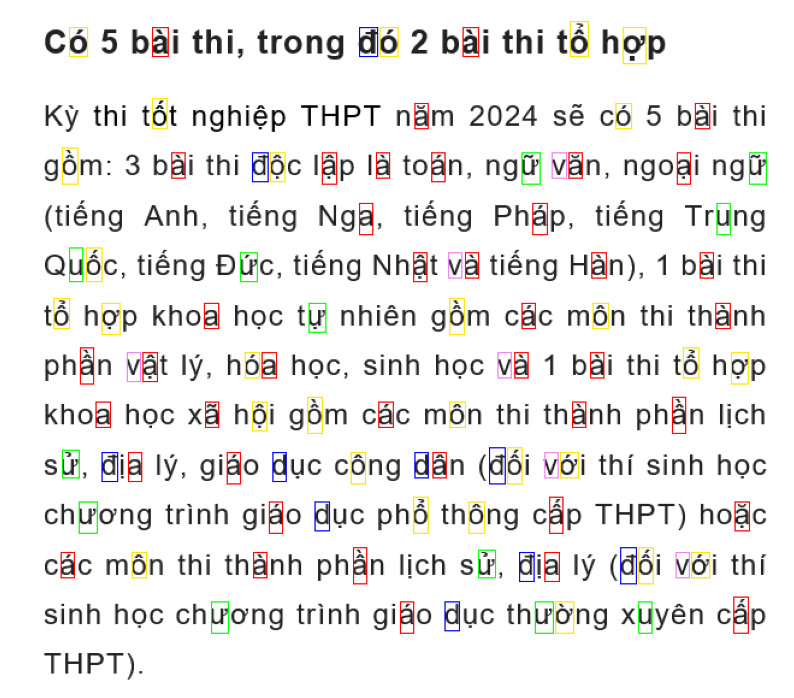

Kích thước mẫu: (105640, 784)
1/1 [==============================] - 0s 19ms/step


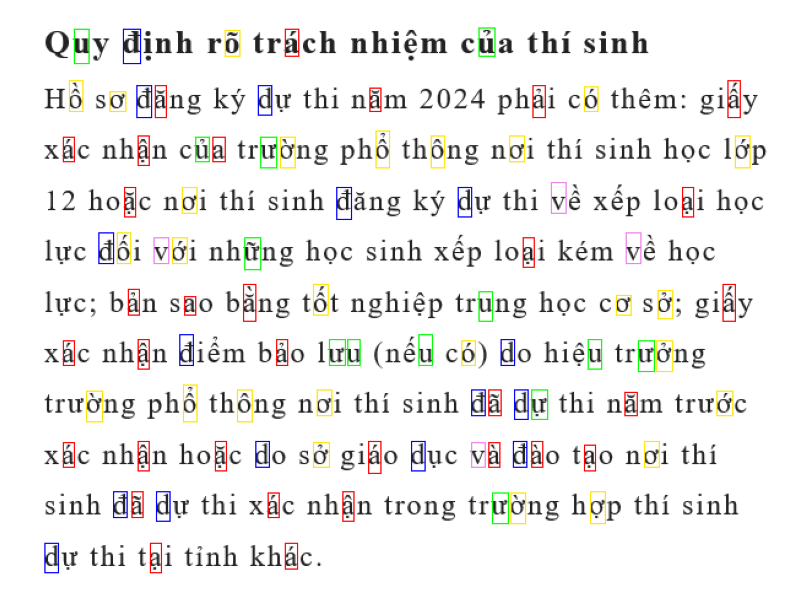

Kích thước mẫu: (105640, 784)
1/1 [==============================] - 0s 18ms/step


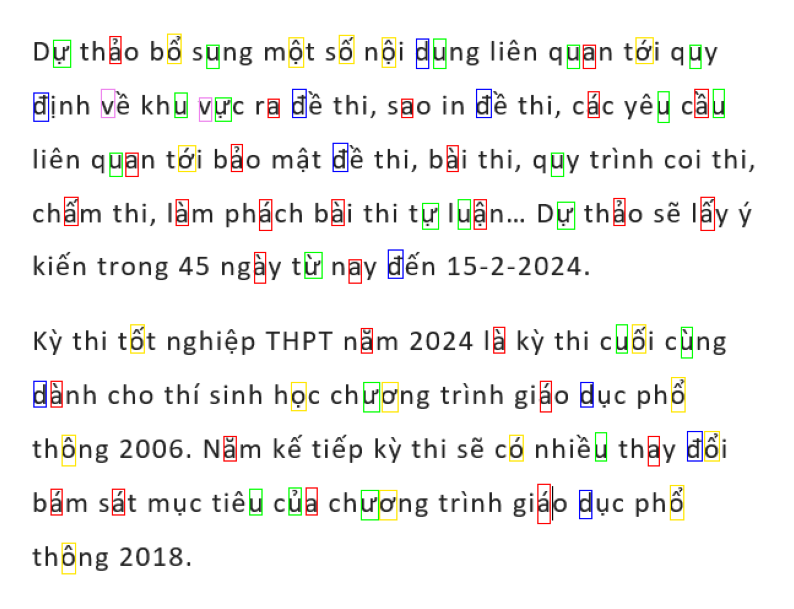

Kích thước mẫu: (105640, 784)
1/1 [==============================] - 0s 18ms/step


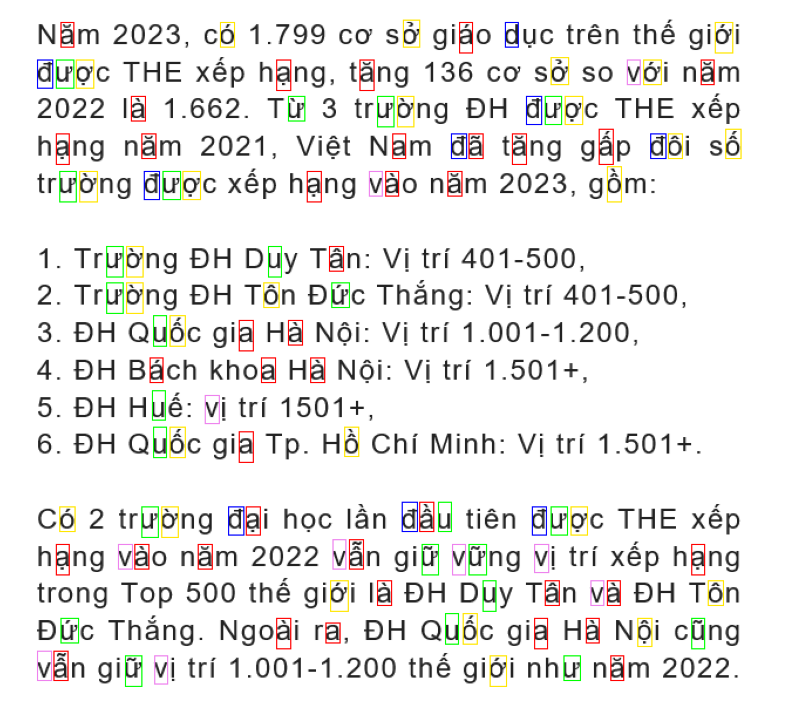

Kích thước mẫu: (105640, 784)
1/1 [==============================] - 0s 37ms/step


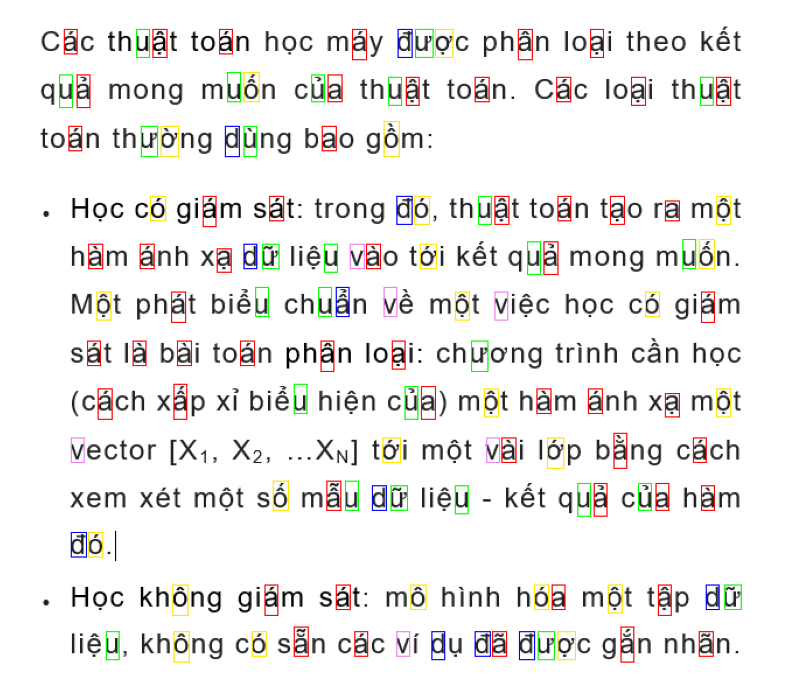

In [25]:
# Mảng các bức ảnh đầu vào
img_paths = ["test1.jpg", "test2.jpg", "test3.jpg", "test4.jpg", "test5.jpg"]

# Chạy hàm run cho mỗi ảnh trong danh sách
for img_path in img_paths:
    run(img_path, model, "vi.characters.csv")